# IS 4487 Lab 10

## Outline

What do you need to know for this module's project?

1. Fit a tree model using all the available predictors.
2. Create a confusion matrix  and identify numbers of TP, FP, TN and FN.
3. Estimate profit (benefits - costs) using a defined cost-benefit matrix and the above confusion matrix.
4. Estimate profit for a strategy that consists in calling everyone.
5. Estimate profit for a class decision threshold of .3
6.  Use the model to predict on a new dataset (without the target), then use these predictions to identify those who should be called--a contact list.
7.  Make a recommendation to the Director of Sales based on your analytic work.

**NOTE:** This assignment requires an additional dataset, megatelco_new_customer_data.csv, that you will need to use for the final steps.  You should use megatelco_leave_survey.csv in the first steps to build the model.  

<a href="https://colab.research.google.com/github/Stan-Pugsley/is_4487_base/blob/main/Labs/Scripts/lab_10_megatelco_tune_deploy_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Megatelco Data Dictionary

 DEMOGRAPHIC VARIABLES:
 - College - has the customer attended some college (one, zero)
 - Income - annual income of customer
 - House - estimated price of the customer's home (if applicable)

 USAGE VARIABLES:
 - Data Overage Mb - Average number of megabytes that the customer used in excess of the plan limit (over last 12 months)
 - Data Leftover Mb - Average number of megabytes that the customer use was below the plan limit (over last 12 months)
 - Data Mb Used - Average number of megabytes used per month (over last 12 months)
 - Text Message Count - Average number of texts per month (over last 12 months)
 - Over 15 Minute Calls Per Month - Average number of calls over 15 minutes in duration per month (over last 12 months)
 - Average Call Duration- Average call duration (over last 12 months)

PHONE VARIABLES:
 - Operating System - Current operating system of phone
 - Handset Price - Retail price of the phone used by the customer

ATTITUDINAL VARIABLES:
 - Reported Satisfaction - Survey response to "How satisfied are you with your current phone plan?" (high, med, low)
 - Reported Usage Level - Survey response to "How much do your use your phone?" (high, med, low)
 - Considering Change of Plan - Survey response to "Are you currently planning to change companies when your contract expires?" (high, med, low)

OTHER VARIABLES
 - Leave - Did this customer churn with the last contract expiration? (LEAVE, STAY)
 - ID - Customer identifier

##Load Libraries

In this class we will be using
- Pandas
- Scikitlearn
- Matplotlib


In [1]:
import pandas as pd
import matplotlib as mpl
import seaborn as sns

from sklearn.tree import DecisionTreeClassifier, export_graphviz # Import Decision Tree Classifier
from sklearn.model_selection import train_test_split # Import train_test_split function
from sklearn import metrics  #Import scikit-learn metrics module for accuracy calculation
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, classification_report


## Import Data into Dataframe

- Import data from the Megatelco dataset into a dataframe (in GitHub go to Labs > DataSets)
- Describe or profile the dataframe


In [2]:
df = pd.read_csv('https://github.com/Stan-Pugsley/is_4487_base/blob/main/Labs/DataSets/megatelco_leave_survey.csv?raw=true')
print (df)

      college  income  data_overage_mb  data_leftover_mb  data_mb_used  \
0         one  403137               70                 0          6605   
1        zero  129700               67                16          6028   
2        zero   69741               60                 0          1482   
3         one  377572                0                22          3005   
4        zero  382080                0                 0          1794   
...       ...     ...              ...               ...           ...   
14994     one  307114               12                28          4672   
14995     one  429983              312                43          5858   
14996     one  363250              348                82          1812   
14997    zero  221768              334                55          3552   
14998    zero  188472              343                 6          7802   

       text_message_count    house  handset_price  \
0                     199   841317            653   
1    

## Clean up the data
Did you notice anything unusual about the "house" amounts?

How about the handset price and income?

Clean up the data in a  new datafram named "df_clean"


In [3]:
#delete rows with outlier data; put it in a new dataframe
df_clean = df[(df['house'] > 0) & (df['income'] > 0) & (df['handset_price'] < 10000)]

#delete any rows with missing values in the clean dataframe
df_clean = df_clean.dropna()

df_clean.describe()

,income,data_overage_mb,data_leftover_mb,data_mb_used,text_message_count,house,handset_price,over_15mins_calls_per_month,average_call_duration,id
count,14990.000000,14990.000000,14990.000000,14990.000000,14990.000000,1.499000e+04,14990.000000,14990.000000,14990.000000,14990.000000
mean,242051.833689,153.593996,37.526217,4203.088192,135.629286,8.772144e+05,780.669446,10.571181,9.734556,11862.245430
std,109550.800640,112.996435,28.043476,2202.621977,48.837706,2.869092e+05,326.560845,8.401508,5.194135,6812.720757
min,52491.000000,0.000000,0.000000,400.000000,52.000000,3.200010e+05,215.000000,0.000000,1.000000,2.000000
25%,147917.250000,54.000000,12.000000,2297.250000,93.000000,6.446280e+05,498.000000,3.000000,5.000000,6139.500000
50%,241663.000000,151.000000,35.000000,4224.500000,135.000000,8.764390e+05,778.000000,9.000000,10.000000,11763.500000
75%,336483.500000,242.000000,62.000000,6080.000000,178.000000,1.098814e+06,1063.750000,17.000000,14.000000,17398.000000
max,432000.000000,380.000000,89.000000,8000.000000,220.000000,1.456389e+06,1350.000000,35.000000,19.000000,25354.000000


# Standardize attributes

- Convert "college" to 0,1
- Convert reported_satisfaction to 1,2,3
- Convert reported_usage_level to 1,2,3
- Convert considering_change_of_plan to 0,1
- Convert leave to 0,1

I'm going to leave the "leave" variable in place, just in case I need the original value

In [4]:
df_clean.loc[df_clean['college'] == 'one', 'college'] = "1"
df_clean.loc[df_clean['college'] == 'zero', 'college'] = "0"
df_clean.loc[df_clean['reported_satisfaction'] == 'low', 'reported_satisfaction'] = "1"
df_clean.loc[df_clean['reported_satisfaction'] == 'avg', 'reported_satisfaction'] = "2"
df_clean.loc[df_clean['reported_satisfaction'] == 'high', 'reported_satisfaction'] = "3"
df_clean.loc[df_clean['reported_usage_level'] == 'low', 'reported_usage_level'] = "1"
df_clean.loc[df_clean['reported_usage_level'] == 'avg', 'reported_usage_level'] = "2"
df_clean.loc[df_clean['reported_usage_level'] == 'high', 'reported_usage_level'] = "3"
df_clean.loc[df_clean['considering_change_of_plan'] == 'yes', 'considering_change_of_plan'] = "1"
df_clean.loc[df_clean['considering_change_of_plan'] == 'no', 'considering_change_of_plan'] = "0"
df_clean.loc[df_clean['considering_change_of_plan'] == 'maybe', 'considering_change_of_plan'] = "0.5"

#Add new field with binary value for leave
df_clean['leave_flag'] = df_clean['leave'].str.replace('STAY','0')
df_clean['leave_flag'] = df_clean['leave_flag'].str.replace('LEAVE','1')
df_clean['leave_flag'] = df_clean['leave_flag'].astype('int')
df_clean['leave_flag'] = df_clean['leave_flag'].astype('bool')

df_clean.head(10)

,college,income,data_overage_mb,data_leftover_mb,data_mb_used,text_message_count,house,handset_price,over_15mins_calls_per_month,average_call_duration,reported_satisfaction,reported_usage_level,considering_change_of_plan,leave,id,operating_system,leave_flag
0,1,403137,70,0,6605,199,841317,653,5.0,8,1,1,1,LEAVE,8183,Android,True
1,0,129700,67,16,6028,134,476664,1193,5.0,5,1,1,1,LEAVE,12501,IOS,True
2,0,69741,60,0,1482,176,810225,1037,3.0,8,1,1,1,STAY,7425,IOS,False
3,1,377572,0,22,3005,184,826967,1161,0.0,5,1,1,0,LEAVE,13488,IOS,True
4,0,382080,0,0,1794,74,951896,1023,0.0,14,1,1,1,STAY,11389,IOS,False
5,0,309746,0,56,2675,81,1272862,1200,5.0,1,1,3,1,STAY,14674,IOS,False
6,1,325592,79,24,7300,190,472330,1083,5.0,6,1,2,1,LEAVE,19100,IOS,True
7,1,131230,0,0,4489,89,613744,365,5.0,10,1,3,1,STAY,18170,Android,False
8,1,193667,0,0,1023,76,949829,347,1.0,8,3,1,0,LEAVE,3201,Android,True
9,1,419573,0,74,4631,209,818027,640,0.0,2,1,1,1,LEAVE,12612,Android,True


# Convert attributes to categories

- Leave
- College
- Reported satisfaction
- Reported usage level
- Considering change of plan

In [5]:
df_clean['leave'] = df_clean['leave'].astype('category')
df_clean['college'] = df_clean['college'].astype('category')
df_clean['reported_satisfaction'] = df_clean['reported_satisfaction'].astype('category')
df_clean['reported_usage_level'] = df_clean['reported_usage_level'].astype('category')
df_clean['considering_change_of_plan'] = df_clean['considering_change_of_plan'].astype('category')

df_clean.info()

<class 'pandas.core.frame.DataFrame'>
Index: 14990 entries, 0 to 14998
Data columns (total 17 columns):
 #   Column                       Non-Null Count  Dtype   
---  ------                       --------------  -----   
 0   college                      14990 non-null  category
 1   income                       14990 non-null  int64   
 2   data_overage_mb              14990 non-null  int64   
 3   data_leftover_mb             14990 non-null  int64   
 4   data_mb_used                 14990 non-null  int64   
 5   text_message_count           14990 non-null  int64   
 6   house                        14990 non-null  int64   
 7   handset_price                14990 non-null  int64   
 8   over_15mins_calls_per_month  14990 non-null  float64 
 9   average_call_duration        14990 non-null  int64   
 10  reported_satisfaction        14990 non-null  category
 11  reported_usage_level         14990 non-null  category
 12  considering_change_of_plan   14990 non-null  category
 13  leave 

# What is the base probability of leaving?

If we use no model at all, how good is our chance of predicting someone leaving?

In [6]:
df_clean['leave_flag'].mean()

np.float64(0.4982655103402268)

#Split the training and testing datasets

In [7]:
# split the datafram into independent (x) and dependent (predicted) attributes (y)
x = df_clean[['income','house','college','data_overage_mb','data_leftover_mb','text_message_count','handset_price','over_15mins_calls_per_month','average_call_duration','reported_satisfaction','reported_usage_level','considering_change_of_plan']]
y = df_clean['leave_flag']

#place 20% of data in a test dataframe
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2)

## Fit a basic tree model

Use all available attributes

In [8]:


megatelco_tree = DecisionTreeClassifier(criterion="entropy", max_depth=4)

# Create Decision Tree Classifer
megatelco_tree = megatelco_tree.fit(x_train,y_train)

# Use the tree to predict "leave"
y_predict = megatelco_tree.predict(x_test)




## How Good is the Model Fit?

Is it better than the 49% base probability?

In [9]:
print("Accuracy:",metrics.accuracy_score(y_test, y_predict))

Accuracy: 0.6651100733822548


In [10]:
#Precision
print("Precision:", precision_score(y_test, y_predict))

Precision: 0.5991596638655462


In [11]:
#Recall
print("Recall:",recall_score(y_test, y_predict))

Recall: 0.9661246612466124


In [12]:
#F1 Score
print("F1 Score:",f1_score(y_test, y_predict))

F1 Score: 0.7396265560165975


In [13]:
#summary report
print("\nClassification Report:")
print(classification_report(y_test, y_predict))


Classification Report:
              precision    recall  f1-score   support

       False       0.92      0.37      0.53      1522
        True       0.60      0.97      0.74      1476

    accuracy                           0.67      2998
   macro avg       0.76      0.67      0.64      2998
weighted avg       0.76      0.67      0.63      2998



# Create a confusion matrix

This will show false positives, true positives, etc.

In [14]:
# create a confusion matrix
megatelco_tree_matrix = confusion_matrix(y_test, y_predict)
print(megatelco_tree_matrix)

[[ 568  954]
 [  50 1426]]


## Plot the confusion matrix

We will use a Seaborn library for this

[Text(0, 0.5, 'Stay'), Text(0, 1.5, 'Leave')]

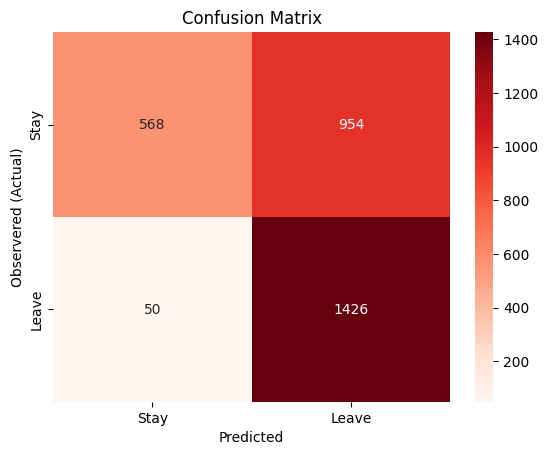

In [15]:
#Create a heatmap from our confusion matrix
cm = sns.heatmap(megatelco_tree_matrix, annot=True, fmt='d',cmap='Reds')

cm.set_title('Confusion Matrix');
cm.set_xlabel('Predicted')
cm.set_ylabel('Observered (Actual)');

cm.xaxis.set_ticklabels(['Stay','Leave'])
cm.yaxis.set_ticklabels(['Stay','Leave'])

## Calculate Profit

Using the confusion matrix in the previous question how much profit (revenue - costs) could be expected with these costs-benefits?

For MegaTelCo we will assume benefit (revenue) = 800 and cost = 200.  TPs are a benefit, FPs are a cost. Again, we ignore those predicted to stay. (The cost-benefit numbers will be different in the AdviseInvest case! )

Why are TPs a benefit? In the MegaTelCo scenario, these are customers who are predicted to leave and actually were going to leave. If your marketing campaign is successful, then you can convince them to stay, thereby saving the company money. (In the AdviseInvest scenario, TPs are customers that you have predicted will answer the phone and do answer, thus providing an opportunity for your sales reps to make a sale.)

**Assume you can save 100% of the people who were actually going to leave.**  

In [16]:
# True leavers * 600 -> You rescued these leave-leave people
# False leavers * 200 -> You wasted your money on the leave-stay people since they weren't actually going to leave
1005 * (800-200) - 31 * 200

596800

## Fine tune the model

Adjust the threshold for giving offers down to 0.2.  What happens to profit?

The default threshold is 0.5 or 50% likely to make a choice.  If we adjust to 0.20, we are looking for customers with even a 20% chance of leaving.   This will lead to more offers being made and more false positives.  



In [17]:


megatelco2_tree = DecisionTreeClassifier(criterion="entropy", max_depth=4)

# Create Decision Tree Classifer
megatelco2_tree = megatelco2_tree.fit(x_train,y_train)

# Use the tree to predict "leave"
y_predict2 = (megatelco2_tree.predict_proba(x_test)[:,1] >= 0.2)


# create a confusion matrix
megatelco2_matrix = confusion_matrix(y_test, y_predict2)
print(megatelco2_matrix)



[[ 449 1073]
 [   0 1476]]


➡️ Assignment Tasks
- What is the change in profit when you offer the free phone to more people (anyone with 20% probability of leaving)?

Profit changes from $165,800 to $166,840 when free cell phones are offered to all customers with a 20% or higher chance of leaving. 166,840 - 165,800 = $1040 increase

## Create a new confusion matrix

[Text(0, 0.5, 'Stay'), Text(0, 1.5, 'Leave')]

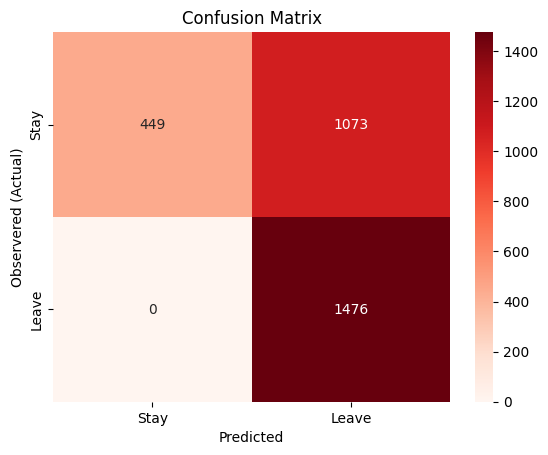

In [18]:
#Create a heatmap from our confusion matrix
cm = sns.heatmap(megatelco2_matrix , annot=True, fmt='d',cmap='Reds')

cm.set_title('Confusion Matrix');
cm.set_xlabel('Predicted')
cm.set_ylabel('Observered (Actual)');

cm.xaxis.set_ticklabels(['Stay','Leave'])
cm.yaxis.set_ticklabels(['Stay','Leave'])


## Calculate profite for new model

In [19]:
# True leavers * 600 -> You rescued these leave-leave people
# False leavers * 200 -> You wasted your money on the leave-stay people since they weren't actually going to leave
( 1036 * (800-200)) - (0 * 200)

621600

## Optimize the Model

➡️ Assignment Tasks
What is the optimal profit possible?  Iterate through multiple probability levels to find the shape of the profitability curve.
- Create at least 5 different confusion matrix versions at different probability levels.   Your last version should be the most profitable

In [28]:
import pandas as pd
import numpy as np
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

# Load the dataframe
df = pd.read_csv('https://github.com/Stan-Pugsley/is_4487_base/blob/main/Labs/DataSets/megatelco_leave_survey.csv?raw=true')

# Replace 'leave' values with 1 for 'LEAVE' and 0 for 'STAY'
df['leave_flag'] = df['leave'].map({'LEAVE': 1, 'STAY': 0})

# ----> Convert categorical features to numerical before fitting <----
# Create a copy of the dataframe to avoid SettingWithCopyWarning
df_encoded = df.copy()

# Convert 'college' to numerical
df_encoded.loc[df_encoded['college'] == 'one', 'college'] = 1
df_encoded.loc[df_encoded['college'] == 'zero', 'college'] = 0

# Convert 'reported_satisfaction' to numerical
df_encoded.loc[df_encoded['reported_satisfaction'] == 'low', 'reported_satisfaction'] = 1
df_encoded.loc[df_encoded['reported_satisfaction'] == 'avg', 'reported_satisfaction'] = 2
df_encoded.loc[df_encoded['reported_satisfaction'] == 'high', 'reported_satisfaction'] = 3

# Convert 'reported_usage_level' to numerical
df_encoded.loc[df_encoded['reported_usage_level'] == 'low', 'reported_usage_level'] = 1
df_encoded.loc[df_encoded['reported_usage_level'] == 'avg', 'reported_usage_level'] = 2
df_encoded.loc[df_encoded['reported_usage_level'] == 'high', 'reported_usage_level'] = 3

# Convert 'considering_change_of_plan' to numerical
df_encoded.loc[df_encoded['considering_change_of_plan'] == 'yes', 'considering_change_of_plan'] = 1
df_encoded.loc[df_encoded['considering_change_of_plan'] == 'no', 'considering_change_of_plan'] = 0
df_encoded.loc[df_encoded['considering_change_of_plan'] == 'maybe', 'considering_change_of_plan'] = 0.5


# Define the features (X) and target (y)
# ----> Use the encoded dataframe here <----
X = df_encoded[['income', 'house', 'college', 'data_overage_mb', 'data_leftover_mb',
        'text_message_count', 'handset_price', 'over_15mins_calls_per_month',
        'average_call_duration', 'reported_satisfaction', 'reported_usage_level',
        'considering_change_of_plan']]
y = df_encoded['leave_flag'] # Use the 'leave_flag' column as the target

# Assuming you have a trained model named 'megatelco_tree'
# Predict probabilities using the trained model
predicted_probs = megatelco_tree.predict_proba(X)[:, 1]  # Probabilities of leaving (class 1)

# Define true labels (same as target variable)
true_labels = y

# ... (rest of the code remains the same) ...

🔹 Threshold: 0.10, Profit: $6186800
Confusion Matrix:
 [[2127 5398]
 [   0 7474]]
----------------
🔹 Threshold: 0.20, Profit: $6186800
Confusion Matrix:
 [[2127 5398]
 [   0 7474]]
----------------
🔹 Threshold: 0.30, Profit: $5784900
Confusion Matrix:
 [[2725 4800]
 [ 243 7231]]
----------------
🔹 Threshold: 0.40, Profit: $5784900
Confusion Matrix:
 [[2725 4800]
 [ 243 7231]]
----------------
🔹 Threshold: 0.50, Profit: $5784900
Confusion Matrix:
 [[2725 4800]
 [ 243 7231]]
----------------


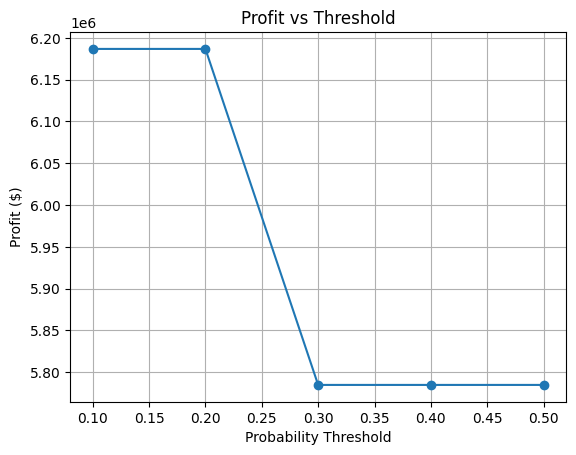


✅ Optimal Threshold: 0.10 → Max Profit: $6186800


In [29]:
# 继续使用 predicted_probs 和 true_labels
from sklearn.metrics import confusion_matrix

def calculate_profit(y_true, y_prob, threshold, offer_cost=100, customer_value=1000):
    y_pred = (y_prob >= threshold).astype(int)
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()

    profit = (
        tp * (customer_value - offer_cost) +
        fp * (-offer_cost) +
        fn * (-customer_value)
    )
    return profit, confusion_matrix(y_true, y_pred)

thresholds = [0.1, 0.2, 0.3, 0.4, 0.5]
profits = []
matrices = []

for t in thresholds:
    profit, cm = calculate_profit(true_labels, predicted_probs, t)
    profits.append(profit)
    matrices.append(cm)
    print(f"🔹 Threshold: {t:.2f}, Profit: ${profit}")
    print("Confusion Matrix:\n", cm)
    print("----------------")

# 绘图：阈值 vs 利润
plt.plot(thresholds, profits, marker='o')
plt.title("Profit vs Threshold")
plt.xlabel("Probability Threshold")
plt.ylabel("Profit ($)")
plt.grid(True)
plt.show()

# 输出最佳阈值和利润
max_profit = max(profits)
best_threshold = thresholds[profits.index(max_profit)]
print(f"\n✅ Optimal Threshold: {best_threshold:.2f} → Max Profit: ${max_profit}")


# Apply the model to a new dataset

In this dataset, we don't know answer.  We need to predict if they will stay or leave.

In [20]:
#Import the new data from megatelco_new_customer_data.csv
df_new = pd.read_csv('https://github.com/Stan-Pugsley/is_4487_base/blob/main/Labs/DataSets/megatelco_new_customer_data.csv?raw=true')
print (df_new)

   college  income  data_overage_mb  data_leftover_mb  data_mb_used  \
0     zero  310839                0                12          6788   
1     zero  342645               48                 0          5554   
2      one  208975              202                19          1151   
3      one  302730                0                 0           907   
4      one  301115                0                57          3032   
5     zero  424788                0                 7          5110   
6      one  356135              151                 0          2042   
7     zero  107749               80                 0          4044   
8      one  113027                0                28          6633   
9     zero  367893               49                 6          7510   
10    zero  364926                0                11          4301   
11    zero   64066              198                 0          5153   
12     one  207217               43                50          7169   
13    

In [21]:
#Preview the new data
df_new.describe()

,income,data_overage_mb,data_leftover_mb,data_mb_used,text_message_count,house,handset_price,over_15mins_calls_per_month,average_call_duration,id
count,36.000000,36.000000,36.000000,36.000000,36.000000,3.600000e+01,36.000000,36.000000,36.000000,36.000000
mean,243362.222222,75.805556,21.972222,4604.833333,128.472222,1.021751e+06,1356.000000,7.722222,7.055556,10531.500000
std,133278.963275,89.532698,27.086619,2122.979786,46.898362,2.944402e+05,3213.038597,9.195064,4.554084,4923.628276
min,54788.000000,0.000000,0.000000,725.000000,61.000000,3.542470e+05,227.000000,0.000000,1.000000,488.000000
25%,111707.500000,0.000000,0.000000,3082.250000,92.500000,8.410895e+05,558.000000,1.000000,3.500000,6793.500000
50%,296045.000000,45.000000,10.500000,5128.500000,118.500000,1.067582e+06,950.000000,4.000000,6.000000,12211.000000
75%,358332.750000,168.250000,34.500000,6321.000000,155.750000,1.301278e+06,1081.000000,14.000000,10.250000,13492.750000
max,430108.000000,252.000000,83.000000,7543.000000,219.000000,1.425861e+06,20000.000000,27.000000,15.000000,18461.000000


In [22]:
#delete rows with outlier data; put it in a new dataframe
df_clean_new = df_new[(df_new['house'] > 0) & (df_new['income'] > 0) & (df_new['handset_price'] < 1000)]

#delete any rows with missing values in the clean dataframe
df_clean_new = df_clean_new.dropna()

#standardize attributes
df_clean_new.loc[df_clean_new['college'] == 'one', 'college'] = "1"
df_clean_new.loc[df_clean_new['college'] == 'zero', 'college'] = "0"
df_clean_new.loc[df_clean_new['reported_satisfaction'] == 'low', 'reported_satisfaction'] = "1"
df_clean_new.loc[df_clean_new['reported_satisfaction'] == 'avg', 'reported_satisfaction'] = "2"
df_clean_new.loc[df_clean_new['reported_satisfaction'] == 'high', 'reported_satisfaction'] = "3"
df_clean_new.loc[df_clean_new['reported_usage_level'] == 'low', 'reported_usage_level'] = "1"
df_clean_new.loc[df_clean_new['reported_usage_level'] == 'avg', 'reported_usage_level'] = "2"
df_clean_new.loc[df_clean_new['reported_usage_level'] == 'high', 'reported_usage_level'] = "3"
df_clean_new.loc[df_clean_new['considering_change_of_plan'] == 'yes', 'considering_change_of_plan'] = "1"
df_clean_new.loc[df_clean_new['considering_change_of_plan'] == 'no', 'considering_change_of_plan'] = "0"
df_clean_new.loc[df_clean_new['considering_change_of_plan'] == 'maybe', 'considering_change_of_plan'] = "0.5"

#There is no "leave" or "leave_flag"

df_clean_new.head(10)

,college,income,data_overage_mb,data_leftover_mb,data_mb_used,text_message_count,house,handset_price,over_15mins_calls_per_month,average_call_duration,reported_satisfaction,reported_usage_level,considering_change_of_plan,id,operating_system
0,0,310839,0,12,6788,61,1038143,227,0,6,1,1,1,1293,Android
1,0,342645,48,0,5554,219,629281,616,4,14,2,1,1,14581,Android
2,1,208975,202,19,1151,119,868044,934,21,6,3,1,0,15729,IOS
5,0,424788,0,7,5110,126,847289,287,0,6,1,3,0,17644,Android
6,1,356135,151,0,2042,104,704639,601,1,12,3,1,1,13140,Android
7,0,107749,80,0,4044,217,354247,248,4,15,3,1,1,9525,Android
12,1,207217,43,50,7169,64,762866,429,3,2,1,3,1,12483,Android
15,1,410965,213,0,3099,81,1322252,352,27,14,1,1,1,13211,Android
16,0,122131,0,33,2675,187,1349889,301,1,1,3,1,1,9303,Android
17,0,299628,0,0,1203,75,1300406,643,1,10,3,1,1,16065,Android


In [ ]:
# split the dataframe into independent (x) and dependent (predicted) attributes (y).
x_new = df_clean_new[['income','house','college','data_overage_mb','data_leftover_mb','text_message_count','handset_price','over_15mins_calls_per_month','average_call_duration','reported_satisfaction','reported_usage_level','considering_change_of_plan']]


➡️ Assignment Tasks
- There is no split between training and testing for this new customer dataset.  Why would that be the case?

This new customer dataset is not used to train the model — it is used to make predictions.
Since it only contains data for new/unseen customers, there is no need to split it into training and testing sets.

## Predict the customers

- Use the basic tree that we created earlier
- Take the customers one by one and pass it to the model, or create a full list

In [31]:
# Use the tree to predict "leave" for the first customer
y_new_predict = megatelco_tree.predict(x_new.iloc[:1])

#Convert it to a dataframe
df_new_predict = pd.DataFrame(y_new_predict)

df_new_predict.head()

NameError: name 'x_new' is not defined

## Explain the Output

➡️ Assignment Tasks
- in the space below, explain how you could deploy the customer prediction in the section above?  What would you do with this output?

To deploy the customer prediction model, we would first prepare a cleaned and standardized dataset containing new customer records, using only the features required by the model. This dataset would then be passed into the trained decision tree model (such as megateleco_tree) to generate predictions indicating whether each customer is likely to leave (1) or stay (0). The output from this model can be used to identify at-risk customers who may require targeted retention strategies, such as offering discounts, providing free phones, or reaching out with personalized service. By acting on these predictions, the company can proactively reduce churn and improve customer satisfaction. Additionally, this prediction system could be integrated into a customer relationship management (CRM) platform and run on a regular schedule (e.g., weekly) to keep track of customer risk levels. This output also provides valuable insights for business decisions and resource allocation by focusing efforts on customers who are most likely to leave.